
Write a **Python program** that implements both the **Explicit Method (Forward Euler)** and the **Crank–Nicolson Method** to solve the following **parabolic partial differential equation (PDE):**

$$
\begin{aligned}
\text{PDE:} \quad & \frac{\partial u}{\partial t} = \frac{\partial^2 u}{\partial x^2}, \quad -1 < x < 1, \quad t > 0,\\
\text{Initial Condition:} \quad & u(x, 0) = e^{-x^2 / (0.2)^2},\\
\text{Boundary Conditions:} \quad & u(-1, t) = 0, \\
& u(1, t) = 0.
\end{aligned}
$$

Implement both time-stepping schemes in Python.

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg

# --- PDE Parameters ---
T_final = 0.03  # Final time 

# Initial condition
def initial_condition(x):
    return np.exp(-x**2 / (0.2**2))

# Boundary conditions
g_0 = lambda t: 0.0
g_1 = lambda t: 0.0

In [28]:
def solve_explicit(m, T_final):
    # 1. Create the spatial grid x from -1.0 to 1.0 with m points.
    x = np.linspace(-1.0, 1.0, m)
    delta_x = x[1] - x[0]
    assert m >= 3, "m debe ser ≥ 3 para tener puntos interiores"

    # 2. Set the time step delta_t from the stability condition (dt <= 0.5 * delta_x**2).
    delta_t_stable = 0.5 * (delta_x ** 2)
    N = int(np.ceil(T_final / delta_t_stable))
    #delta_t = T_final / N
    delta_t = 0.5 * delta_x**2
    t = np.linspace(0.0, T_final, N + 1)

    # 3. Initialize the solution array U with the correct shape.
    U = np.zeros((N + 1, m))
    U[0, :] = initial_condition(x)   

    r = delta_t / (delta_x ** 2)     

    # enforce boundary at t=0
    U[0, 0]  = g_0(t[0])             
    U[0, -1] = g_1(t[0])             

    # 4. Time-stepping loop:
    for n in range(N):
        # known boundary at time t[n]
        U[n, 0]  = g_0(t[n])
        U[n, -1] = g_1(t[n])

        # interior update i = 1..m-2
        U[n + 1, 1:-1] = U[n, 1:-1] + r * (U[n, 0:-2] - 2.0 * U[n, 1:-1] + U[n, 2:])

        # apply boundary at time t[n+1]
        U[n + 1, 0]  = g_0(t[n + 1])
        U[n + 1, -1] = g_1(t[n + 1])

    # 5. Return x, t, and U as results.
    return x, t, U

In [ ]:

def solve_crank_nicolson(m, T_final):
    # 1. Create the spatial grid x from -1.0 to 1.0 with m points.
    x = np.linspace(-1.0, 1.0, m)
    delta_x = x[1] - x[0]

    # 2. Define the time step delta_t (e.g., proportional to delta_x for stability).
    #delta_t = 0.1 * delta_x

    delta_t = 0.5 * delta_x**2
    N = int(np.ceil(T_final / delta_t))
    delta_t = T_final / N
    t = np.linspace(0.0, T_final, N + 1)

    # 3. Loop over each time step n:
    U = np.zeros((N + 1, m))
    U[0, :] = initial_condition(x)

    # interior points
    M = m - 2  
    r = delta_t / (2.0 * delta_x**2)

    # tridiagonal matrix
    main = -2.0 * np.ones(M)
    off = 1.0 * np.ones(M - 1)
    Ttri = np.diag(main) + np.diag(off, 1) + np.diag(off, -1)

    A = np.eye(M) - r * Ttri          
    B = np.eye(M) + r * Ttri         

    for n in range(N):
        # BC in time n and n+1
        gL_n, gR_n = g_0(t[n]),     g_1(t[n])
        gL_np1, gR_np1 = g_0(t[n+1]), g_1(t[n+1])

        # BC in time n
        U[n, 0]  = gL_n
        U[n, -1] = gR_n

        # interior at time n
        U_int = U[n, 1:-1]

        # BC
        bc = np.zeros(M)
        bc[0]  += r * (gL_np1 + gL_n)
        bc[-1] += r * (gR_np1 + gR_n)

        # RHS 
        b = B @ U_int + bc
        U_next_int = np.linalg.solve(A, b)

        # capa n+1
        U[n+1, 0]   = gL_np1
        U[n+1, -1]  = gR_np1
        U[n+1, 1:-1] = U_next_int

    # 4. Return x, t, and U as results.

    return x, t, U


**a)** Plot the numerical solution at several time steps (e.g., $t = 0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03$) to visualize the diffusion process and compare the behavior of the **Explicit** and **Crank–Nicolson** methods.



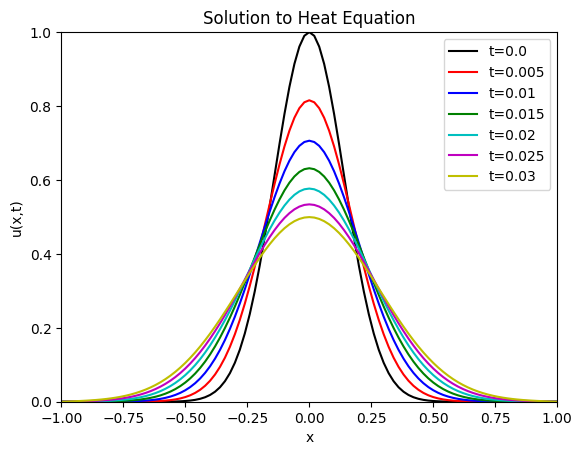

In [30]:
x, t, U = solve_explicit(m=101, T_final=T_final)

# Plot a few solutions
colors = ['k', 'r', 'b', 'g', 'c', 'm', 'y']
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
for (i, n) in enumerate((0, 25, 50, 75, 100, 125,150)):
    axes.plot(x, U[n, :], colors[i], label='t=%s' % np.round(t[n], 4))
    axes.set_xlabel("x")
    axes.set_ylabel("u(x,t)")
    axes.set_title("Solution to Heat Equation")
    axes.set_xlim([-1,1])
    axes.set_ylim([0.0, 1.0])
axes.legend()
plt.show()

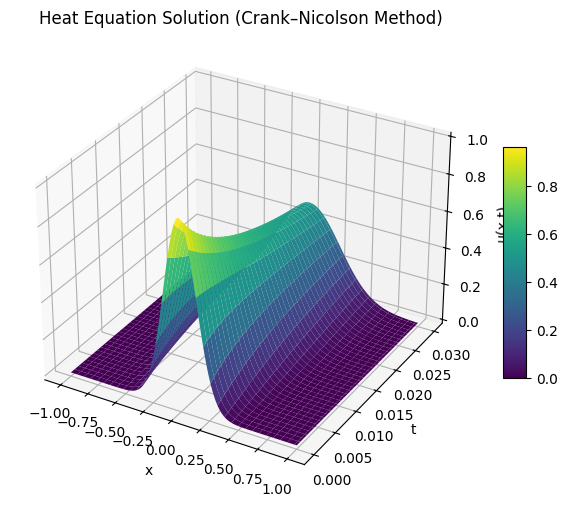

In [31]:
from matplotlib import cm

# Create meshgrid for plotting
X, T = np.meshgrid(x, t)

# Create figure and 3D axis
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(X, T, U, cmap=cm.viridis, edgecolor='none')

# Labels and title
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u(x,t)')
ax.set_title('Heat Equation Solution (Crank–Nicolson Method)')

# Optional color bar
fig.colorbar(surf, shrink=0.5, aspect=10)

plt.show()


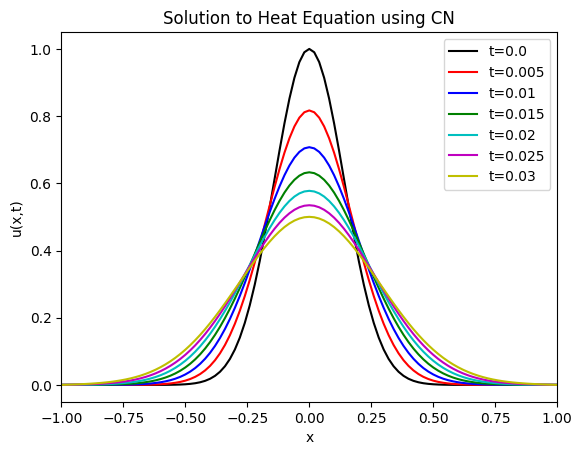

In [32]:
x, t, U = solve_crank_nicolson(m=101, T_final=T_final)

# Plot a few solutions
colors = ['k', 'r', 'b', 'g', 'c', 'm', 'y']
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
for (i, n) in enumerate((0, 25, 50, 75, 100, 125, 150)):
    axes.plot(x, U[n, :], colors[i], label='t=%s' % np.round(t[n], 4))
    axes.set_xlabel("x")
    axes.set_ylabel("u(x,t)")
    axes.set_title("Solution to Heat Equation using CN")
    axes.set_xlim([-1,1])
axes.legend()
plt.show()

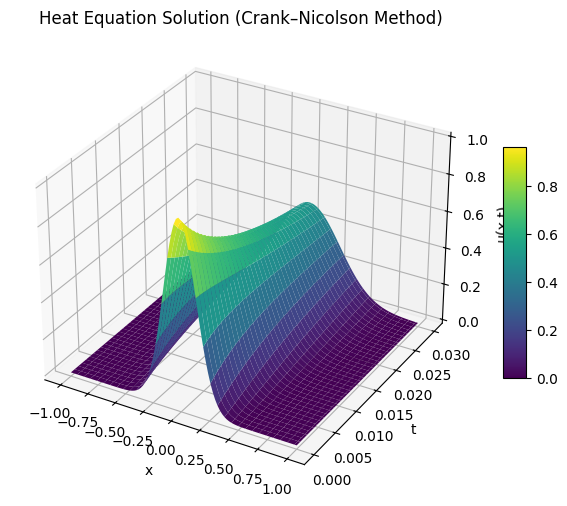

In [ ]:
from matplotlib import cm

# Create meshgrid for plotting
X, T = np.meshgrid(x, t)

# Create figure and 3D axis
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(X, T, U, cmap=cm.viridis, edgecolor='none')

# Labels and title
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u(x,t)')
ax.set_title('Heat Equation Solution (Crank–Nicolson Method)')

# Optional color bar
fig.colorbar(surf, shrink=0.5, aspect=10)

plt.show()


**b)** Perform a **convergence analysis in time and space** for $T = 0.03$:

* **Convergence:**
  Fix $k=0.5h^2$ for both methods. 
  Compute the numerical solution for successively refined spatial grids (e.g., `m = [11, 21, 41, 81, 161, 321]`). 
  Compare each result to a reference “exact” or highly resolved numerical solution (`m=641`) to compute the **spatial error**, typically using the $L_2$ or $L_\infty$ norm. 
  Estimate the **order of accuracy in space** by fitting the slope of the log–log plot of error vs. $h$.

In [34]:
import numpy as np

# Calculate the fine-grid solution once
mfine = 641
x_fine, _, U_fine = solve_explicit(m=mfine, T_final=T_final)
U_fine_final = U_fine[-1, :]

errors = []
ms = [11, 21, 41, 81, 161, 321]

print(f"{'m':>5} {'error':>15} {'order':>10}")
print("-" * 32)

for m in ms:
    x, t, U = solve_explicit(m=m, T_final=T_final)
    
    # Step to subsample the fine solution
    step = int((mfine - 1) / (m - 1))
    
    # Compute max error at final time
    error = np.max(np.abs(U[-1, :] - U_fine_final[::step]))
    errors.append(error)
    
    # Compute order if not first row
    if len(errors) == 1:
        order = "-"
    else:
        h1 = 1 / (ms[len(errors)-2] - 1)
        h2 = 1 / (ms[len(errors)-1] - 1)
        order = np.log(errors[-2] / errors[-1]) / np.log(h1 / h2)
        order = f"{order:.2f}"
    
    print(f"{m:5d} {error:15.6e} {order:>10}")


    m           error      order
--------------------------------
   11    1.134592e-01          -
   21    3.928654e-02       1.53
   41    2.939683e-03       3.74
   81    7.223410e-04       2.02
  161    6.588966e-04       0.13
  321    1.563368e-04       2.08


In [35]:
import numpy as np

# Calculate the fine-grid solution once
mfine = 641
x_fine, _, U_fine = solve_crank_nicolson(m=mfine, T_final=T_final)
U_fine_final = U_fine[-1, :]

errors = []
ms = [11, 21, 41, 81, 161, 321]

print(f"{'m':>5} {'error':>15} {'order':>10}")
print("-" * 32)

for m in ms:
    x, t, U = solve_crank_nicolson(m=m, T_final=T_final)
    
    # Step to subsample the fine solution
    step = int((mfine - 1) / (m - 1))

    # Compute max error at final time
    error = np.max(np.abs(U[-1, :] - U_fine_final[::step]))
    errors.append(error)
    
    # Compute order if not first row
    if len(errors) == 1:
        order = "-"
    else:
        h1 = 1 / (ms[len(errors)-2] - 1)
        h2 = 1 / (ms[len(errors)-1] - 1)
        order = np.log(errors[-2] / errors[-1]) / np.log(h1 / h2)
        order = f"{order:.2f}"
    
    print(f"{m:5d} {error:15.6e} {order:>10}")


    m           error      order
--------------------------------
   11    2.232954e-02          -
   21    5.468667e-03       2.03
   41    1.419306e-03       1.95
   81    3.580007e-04       1.99
  161    8.567692e-05       2.06
  321    1.715704e-05       2.32
